# Descriptive analysis of stroke pathway data

## Aim

Describe key pathway statistics

* Restrict data to stroke teams with at least 300 admissions (over three years) and 10 patients receiving thrombolysis.

* Analyse pathway statistics by stroke team, and combined across all stroke teams.

* Repeat team and combined analysis by age category (under aged 80 years, and aged 80+).

* Create histograms of variation in key statistics across stroke teams.

## Import libraries and data

Data has been resticted to stroke teams with at least 300 admissions, with at least 10 patients receiving thrombolysis, over three years.

In [1]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# import data
raw_data = pd.read_csv(
    './../data/2019-11-04-HQIP303-Exeter_MA.csv', low_memory=False)

In [2]:
headings = list(raw_data)
print (headings)

['StrokeTeam', 'PatientUID', 'Pathway', 'S1AgeOnArrival', 'MoreEqual80y', 'S1Gender', 'S1Ethnicity', 'S1OnsetInHospital', 'S1OnsetToArrival_min', 'S1OnsetDateType', 'S1OnsetTimeType', 'S1ArriveByAmbulance', 'S1AdmissionHour', 'S1AdmissionDay', 'S1AdmissionQuarter', 'S1AdmissionYear', 'CongestiveHeartFailure', 'Hypertension', 'AtrialFibrillation', 'Diabetes', 'StrokeTIA', 'AFAntiplatelet', 'AFAnticoagulent', 'AFAnticoagulentVitK', 'AFAnticoagulentDOAC', 'AFAnticoagulentHeparin', 'S2INR', 'S2INRHigh', 'S2INRNK', 'S2NewAFDiagnosis', 'S2RankinBeforeStroke', 'Loc', 'LocQuestions', 'LocCommands', 'BestGaze', 'Visual', 'FacialPalsy', 'MotorArmLeft', 'MotorArmRight', 'MotorLegLeft', 'MotorLegRight', 'LimbAtaxia', 'Sensory', 'BestLanguage', 'Dysarthria', 'ExtinctionInattention', 'S2NihssArrival', 'S2BrainImagingTime_min', 'S2StrokeType', 'S2Thrombolysis', 'Haemorrhagic', 'TimeWindow', 'Comorbidity', 'Medication', 'Refusal', 'Age', 'Improving', 'TooMildSevere', 'TimeUnknownWakeUp', 'OtherMedical

Show data types

In [3]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246676 entries, 0 to 246675
Data columns (total 62 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   StrokeTeam              246676 non-null  object 
 1   PatientUID              246676 non-null  object 
 2   Pathway                 246676 non-null  int64  
 3   S1AgeOnArrival          246676 non-null  object 
 4   MoreEqual80y            246676 non-null  object 
 5   S1Gender                246676 non-null  object 
 6   S1Ethnicity             246676 non-null  object 
 7   S1OnsetInHospital       246676 non-null  object 
 8   S1OnsetToArrival_min    154640 non-null  float64
 9   S1OnsetDateType         246676 non-null  object 
 10  S1OnsetTimeType         246676 non-null  object 
 11  S1ArriveByAmbulance     232503 non-null  object 
 12  S1AdmissionHour         246676 non-null  object 
 13  S1AdmissionDay          246676 non-null  object 
 14  S1AdmissionQuarter  

## Restrict original data to hospitals with at least 300 admissions + 10 thrombolysis patients

In [4]:
keep = []

groups = raw_data.groupby('StrokeTeam') # creates a new object of groups of data

for index, group_df in groups: # each group has an index and a dataframe of data
    
    # Skip if total admissions less than 300 or total thrombolysis < 10
    admissions = group_df.shape[0]
    thrombolysis_received = group_df['S2Thrombolysis'] == 'Yes' 
    if (admissions < 300) or (thrombolysis_received.sum() < 10):
        continue
    
    else: 
        keep.append(group_df)

# Concatenate output
data = pd.DataFrame()
data = pd.concat(keep)

print (data.shape)

(239505, 62)


## Compare thrombolysis use for out-of-hospital and in-hospital stroke onset

In [5]:
# Create boolean feature for use of thrombolysis
data['use_thrombolysis'] = data['S2Thrombolysis'] == 'Yes'

# Show percentage of strokes have in hospital onset
in_hospital_onset = data['S1OnsetInHospital'] == 'Yes'
percent_in_hosp = in_hospital_onset.mean() * 100
print (
    f'Percentage of stroke with in-hospital onset: {percent_in_hosp:0.1f}')

# In hospital onset
mask = data['S1OnsetInHospital'] == 'Yes'
thrombolysis_in = data[mask]['use_thrombolysis'].mean() * 100
print (
    f'Thrombolysis use (%) for in-hospital-onset {thrombolysis_in:0.1f}')

# Out of hospital onset
mask = data['S1OnsetInHospital'] == 'No'
thrombolysis_out = data[mask]['use_thrombolysis'].mean() * 100
print (
    f'Thrombolysis use (%) for out-of-hospital-onset {thrombolysis_out:0.1f}')

Percentage of stroke with in-hospital onset: 5.3
Thrombolysis use (%) for in-hospital-onset 12.3
Thrombolysis use (%) for out-of-hospital-onset 11.8


## Restrict data to out-of-hospital onset

In [6]:
mask = data['S1OnsetInHospital'] == 'No'
data = data[mask]

## Function for analysis by stroke team

In [7]:
def analyse_by_team(input_data):
    
    # Copy data
    data = input_data.copy()
    
    # Set up results lists
    stroke_team = []
    admissions = []
    age_80_plus = []
    
    onset_known = []
    rankin_before_stroke_all = []
    nihss_arrival_all = []
    known_arrival_within_4hrs = []
    rankin_before_stroke_4hrs = []
    nihss_arrival_4hrs = []
    onset_arrival_mins_mu = []
    onset_arrival_mins_sigma = []
    scan_within_4_hrs = []
    arrival_scan_mins_mu = []
    arrival_scan_mins_sigma = []
    scan_needle_mins_mu = []
    scan_needle_mins_sigma = []
    arrival_needle_mins_mu = []
    arrival_needle_mins_sigma = []
    onset_needle_mins_mu = []
    onset_needle_mins_sigma = []
    thrombolysis_rate = []
    thrombolysis_after_180_min = []
    thrombolysis_after_270_min = []
    eligible = []
    
    # Split data by stroke team
    groups = data.groupby('StrokeTeam') # creates a new object of groups of data
    group_count = 0
    for index, group_df in groups: 
        group_count += 1
        
        # Record stroke team
        stroke_team.append(index)

        # Record admission numbers
        admissions.append(group_df.shape[0])

        # Get thrombolysis rate
        thrombolysed = group_df['S2Thrombolysis'] == 'Yes'
        thrombolysis_rate.append(thrombolysed.mean())
        
        # Get Rankin before stroke and NIHSS on arrival
        rankin_before_stroke_all.append(group_df['S2RankinBeforeStroke'].mean())
        nihss_arrival_all.append(group_df['S2NihssArrival'].mean())
        
        # Record onset known proportion and remove rest
        f = lambda x: x in ['Precise', 'Best estimate']
        mask = group_df['S1OnsetTimeType'].apply(f)
        onset_known.append(mask.mean())
        group_df = group_df[mask]

        # Record onset <4 hours and remove rest
        mask = group_df['S1OnsetToArrival_min'] <= 240
        known_arrival_within_4hrs.append(mask.mean())
        group_df = group_df[mask]
        
        # Get Rankin before stroke and NIHSS on arrival
        rankin_before_stroke_4hrs.append(
            group_df['S2RankinBeforeStroke'].mean())
        nihss_arrival_4hrs.append(group_df['S2NihssArrival'].mean())

        # Calc proportion 80+ (of those arriving within 4 hours)
        age_filter = group_df['MoreEqual80y'] == 'Yes'
        age_80_plus.append(age_filter.mean())

        # Get onset to arrival (of those arriving within 4 hours)
        onset_to_arrival = group_df['S1OnsetToArrival_min']
        onset_arrival_mins_mu.append(onset_to_arrival.mean())
        onset_arrival_mins_sigma.append(onset_to_arrival.std())

        # Record scan within 4 hours of arrival (and remove the rest)
        mask = group_df['S2BrainImagingTime_min'] <= 240
        scan_within_4_hrs.append(mask.mean())
        group_df = group_df[mask]

        # Record arrival to scan (of those arriving within 4 hours)
        arrival_to_scan = group_df['S2BrainImagingTime_min']
        arrival_scan_mins_mu.append(arrival_to_scan.mean())
        arrival_scan_mins_sigma.append(arrival_to_scan.std())

        # Thrombolysis given (of those scanned within 4 hours of arrival)
        thrombolysed_mask = group_df['S2Thrombolysis'] == 'Yes'
        eligible.append(thrombolysed_mask.mean())

        # Scan to needle
        thrombolysed = group_df[thrombolysed_mask]
        scan_to_needle = (thrombolysed['S2ThrombolysisTime_min'] - 
                          thrombolysed['S2BrainImagingTime_min'])
        scan_needle_mins_mu.append(scan_to_needle.mean())
        scan_needle_mins_sigma.append(scan_to_needle.std())
        
        # Arrival to needle
        arrival_needle_mins_mu.append(
            thrombolysed['S2ThrombolysisTime_min'].mean())
        arrival_needle_mins_sigma.append(
            thrombolysed['S2ThrombolysisTime_min'].std())
        
        # Onset to needle
        onset_to_needle = (thrombolysed['S1OnsetToArrival_min'] + 
                          thrombolysed['S2ThrombolysisTime_min'])
        onset_needle_mins_mu.append(onset_to_needle.mean())
        onset_needle_mins_sigma.append(onset_to_needle.std())
        
        # Proportions of thrombolysis after 180 or 270 min
        thrombolysis_after_180 = onset_to_needle > 180
        thrombolysis_after_270 = onset_to_needle > 270
        thrombolysis_after_180_min.append(thrombolysis_after_180.mean())
        thrombolysis_after_270_min.append(thrombolysis_after_270.mean())
        
    df = pd.DataFrame()
    df['stroke_team'] = stroke_team
    df['thrombolysis_rate'] = thrombolysis_rate
    df['arrivals'] = admissions
    df['80_plus'] = age_80_plus
    df['rankin_before_stroke_all'] = rankin_before_stroke_all
    df['nihss_arrival_all'] = nihss_arrival_all
    df['onset_known'] = onset_known
    df['known_arrival_within_4hrs'] = known_arrival_within_4hrs
    df['known_arrival_within_4hrs_all'] = \
        df['onset_known'] * df['known_arrival_within_4hrs']
    df['rankin_before_stroke_4hrs'] = rankin_before_stroke_4hrs
    df['nihss_arrival_4hrs'] = nihss_arrival_4hrs
    df['onset_arrival_mins_mu'] = onset_arrival_mins_mu
    df['onset_arrival_mins_sigma'] = onset_arrival_mins_sigma
    df['scan_within_4_hrs'] = scan_within_4_hrs
    df['arrival_scan_mins_mu'] = arrival_scan_mins_mu
    df['arrival_scan_mins_sigma'] = arrival_scan_mins_sigma
    df['eligable'] = eligible
    df['scan_needle_mins_mu'] = scan_needle_mins_mu
    df['scan_needle_mins_sigma'] = scan_needle_mins_sigma
    df['arrival_needle_mins_mu'] = arrival_needle_mins_mu
    df['arrival_needle_mins_sigma'] = arrival_needle_mins_sigma
    df['onset_needle_mins_mu'] = onset_needle_mins_mu
    df['onset_needle_mins_sigma'] = onset_needle_mins_sigma   
    df['thrombolysis_after_180_min'] = thrombolysis_after_180_min
    df['thrombolysis_after_270_min'] = thrombolysis_after_270_min
    
    return df

## Create analysis by team and show summary

In [8]:
analysis_by_team = analyse_by_team(data)
analysis_by_team.to_csv('output/full_analysis_by_team.csv')
summary_by_hospital = analysis_by_team.describe().T
summary_by_hospital

,count,mean,std,min,25%,50%,75%,max
thrombolysis_rate,132.0,0.114536,0.035449,0.015306,0.093239,0.109547,0.133314,0.243174
arrivals,132.0,1718.333333,832.249409,303.000000,1133.000000,1632.500000,2265.250000,6118.000000
80_plus,132.0,0.425635,0.056416,0.292308,0.387089,0.427573,0.457896,0.576220
rankin_before_stroke_all,132.0,1.040435,0.258761,0.512531,0.843626,1.032913,1.202876,1.860384
nihss_arrival_all,132.0,7.393900,0.948271,4.543634,6.698829,7.404792,8.067855,10.277926
onset_known,132.0,0.665679,0.134064,0.344784,0.573593,0.641978,0.752881,0.988275
known_arrival_within_4hrs,132.0,0.600743,0.089733,0.257034,0.557876,0.608542,0.662325,0.813584
known_arrival_within_4hrs_all,132.0,0.392147,0.062162,0.222646,0.352730,0.392458,0.430548,0.558317
rankin_before_stroke_4hrs,132.0,1.052002,0.264767,0.455108,0.877631,1.059910,1.204151,1.843863
nihss_arrival_4hrs,132.0,9.119220,1.107748,6.108696,8.419594,9.168358,9.916195,11.728546


In [9]:
# Save summary to csv
summary_by_hospital.to_csv('output/pathway_summary_by_hopsital.csv')

## Analyse for all patients together

In [10]:
# Set all StrokeTeam to same
single_group = data.copy()
single_group['StrokeTeam'] = "na"
analysis_all = analyse_by_team(single_group).T

# Add means to new DataFrame
stats_by_age = pd.DataFrame()
stats_by_age['all'] = analysis_all[0]

In [11]:
analysis_all.to_csv('output/pathway_summary_all.csv')

## Analysis by under age 80 vs 80+

Repeat general and hospital level analysis by age stratification

In [12]:
# Mask for under 80
mask = data['MoreEqual80y'] == 'No'
data_under_80 = data[mask]
# Mask for 80 plus
mask = data['MoreEqual80y'] == 'Yes'
data_80_plus = data[mask]

### Under age 80

In [13]:
analysis_by_team_under_80 = analyse_by_team(data_under_80)
summary_by_hospital_under_80 = analysis_by_team_under_80.describe().T
summary_by_hospital_under_80

,count,mean,std,min,25%,50%,75%,max
thrombolysis_rate,132.0,0.127182,0.038002,0.013064,0.104283,0.123472,0.150482,0.262436
arrivals,132.0,1003.037879,529.410379,173.000000,636.000000,941.500000,1286.500000,3999.000000
80_plus,132.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
rankin_before_stroke_all,132.0,0.642800,0.204014,0.221030,0.493693,0.609459,0.758040,1.420674
nihss_arrival_all,132.0,6.286699,0.856764,3.749164,5.766698,6.342502,6.799700,9.328110
onset_known,132.0,0.679982,0.130020,0.377171,0.588716,0.660804,0.760079,0.985591
known_arrival_within_4hrs,132.0,0.584347,0.090390,0.222084,0.537210,0.594057,0.649928,0.807645
known_arrival_within_4hrs_all,132.0,0.389793,0.060399,0.212589,0.351842,0.391457,0.423625,0.544338
rankin_before_stroke_4hrs,132.0,0.617723,0.214004,0.148148,0.462979,0.597158,0.752650,1.443884
nihss_arrival_4hrs,132.0,8.085814,1.080190,5.147959,7.459996,8.037950,8.714991,11.512821


In [14]:
summary_by_hospital_under_80.to_csv('output/pathway_summary_by_hopsital_under_80.csv')

In [15]:
 # Set all StrokeTeam to same
single_group = data_under_80.copy()
single_group['StrokeTeam'] = "na"
analysis_all = analyse_by_team(single_group).T
stats_by_age['under_80'] = analysis_all[0]

### Aged 80+

In [16]:
analysis_by_team_80_plus = analyse_by_team(data_80_plus)
summary_by_hospital_80_plus = analysis_by_team_80_plus.describe().T
summary_by_hospital_80_plus

,count,mean,std,min,25%,50%,75%,max
thrombolysis_rate,132.0,0.097072,0.037177,0.015184,0.071957,0.090386,0.118358,0.227273
arrivals,132.0,715.295455,324.288269,130.000000,519.000000,693.500000,887.250000,2119.000000
80_plus,132.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
rankin_before_stroke_all,132.0,1.582028,0.329839,0.799699,1.355713,1.583800,1.794138,2.464387
nihss_arrival_all,132.0,8.949314,1.154855,5.969027,8.166105,8.990764,9.807674,12.285714
onset_known,132.0,0.646519,0.141493,0.310705,0.543596,0.622715,0.740186,0.992000
known_arrival_within_4hrs,132.0,0.624133,0.093277,0.312377,0.577418,0.627499,0.683352,0.821990
known_arrival_within_4hrs_all,132.0,0.395484,0.069188,0.194872,0.355810,0.392473,0.442737,0.601429
rankin_before_stroke_4hrs,132.0,1.638257,0.335931,0.863830,1.395506,1.650321,1.864107,2.386986
nihss_arrival_4hrs,132.0,10.546849,1.371413,6.688889,9.689962,10.640593,11.557606,13.642157


In [17]:
summary_by_hospital_80_plus.to_csv('output/pathway_summary_by_hopsital_80_plus.csv')

In [18]:
 # Set all StrokeTeam to same
single_group = data_80_plus.copy()
single_group['StrokeTeam'] = "na"
analysis_all = analyse_by_team(single_group).T
stats_by_age['80+'] = analysis_all[0]

Show comparison of means by age group

In [19]:
stats_by_age.to_csv('output/summary_by_age_group.csv')
stats_by_age

,all,under_80,80+
stroke_team,na,na,na
thrombolysis_rate,0.118239,0.130445,0.101124
arrivals,226820,132401,94419
80_plus,0.423219,0,1
rankin_before_stroke_all,1.04732,0.654225,1.59853
nihss_arrival_all,7.46584,6.36386,9.05927
onset_known,0.668596,0.681943,0.64988
known_arrival_within_4hrs,0.586399,0.568081,0.613354
known_arrival_within_4hrs_all,0.392064,0.387399,0.398606
rankin_before_stroke_4hrs,1.05969,0.623704,1.65387


## Summary figure

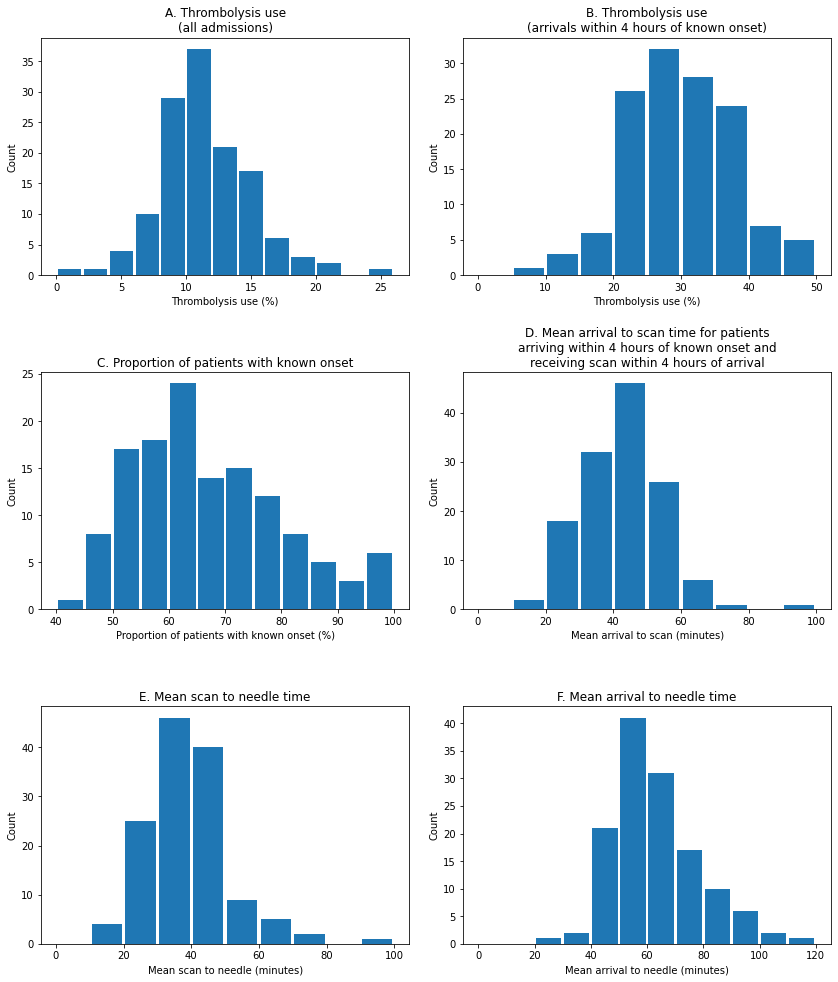

In [20]:
# Set up figure
fig = plt.figure(figsize=(12,14))

# Subplot 1: Histogram of thrombolysis rate
ax1 = fig.add_subplot(321)
x = analysis_by_team['thrombolysis_rate'] * 100
bins = np.arange(0, x.max()+2, 2)
ax1.hist(x, bins=bins, rwidth=0.9)
ax1.set_xlabel('Thrombolysis use (%)')
ax1.set_ylabel('Count')
ax1.set_title('A. Thrombolysis use\n(all admissions)')

# Subplot 2: Histogram of thrombolysis rate for patients arriving in 4 hours
ax2 = fig.add_subplot(322)
x = analysis_by_team['eligable'] * 100
bins = np.arange(0, x.max()+5, 5)
ax2.hist(x, bins=bins, rwidth=0.9)
ax2.set_xlabel('Thrombolysis use (%)')
ax2.set_ylabel('Count')
ax2.set_title('B. Thrombolysis use\n(arrivals within 4 hours of known onset)')

# Subplot 3: Histogram of proportion of patients with known onset
ax3 = fig.add_subplot(323)
x = analysis_by_team['onset_known'] * 100
bins = np.arange(40, x.max()+5, 5)
ax3.hist(x, bins=bins, rwidth=0.9)
ax3.set_xlabel('Proportion of patients with known onset (%)')
ax3.set_ylabel('Count')
ax3.set_title('C. Proportion of patients with known onset')

# Subplot 4: Histogram of mean Arrival to scan times
ax4 = fig.add_subplot(324)
x = analysis_by_team['arrival_scan_mins_mu']
bins = np.arange(0, x.max()+10, 10)
ax4.hist(x, bins=bins, rwidth=0.9)
ax4.set_xlabel('Mean arrival to scan (minutes)')
ax4.set_ylabel('Count')
ax4.set_title('''D. Mean arrival to scan time for patients
arriving within 4 hours of known onset and
receiving scan within 4 hours of arrival''')

# Subplot 5: Histogram of mean scan to needle times
ax5 = fig.add_subplot(325)
x = analysis_by_team['scan_needle_mins_mu']
bins = np.arange(0, x.max()+10, 10)
ax5.hist(x, bins=bins, rwidth=0.9)
ax5.set_xlabel('Mean scan to needle (minutes)')
ax5.set_ylabel('Count')
ax5.set_title('E. Mean scan to needle time')

# Subplot 6: Histogram of mean arrival to needle times
ax6 = fig.add_subplot(326)
x = analysis_by_team['arrival_needle_mins_mu']
bins = np.arange(0, x.max()+10, 10)
ax6.hist(x, bins=bins, rwidth=0.9)
ax6.set_xlabel('Mean arrival to needle (minutes)')
ax6.set_ylabel('Count')
ax6.set_title('F. Mean arrival to needle time')

# Save and show
plt.tight_layout(pad=2)
plt.savefig('output/pathway_summary_six_histograms.jpg', dpi=300)
plt.show();

## General observations

* There are 239,505 admissions (2016-2018) to 132 stroke teams that receive at least 300 admissions and provide thrombolysis to at least 10 patients over the course of three years (2016-2018).

* 5.3% of patients have an in-hospital stroke onset; 12.3% receive thrombolysis. 94.7% of patients have an out-of-hospital stroke onset; 11.8% receive thrombolysis.

The following statistic apply to out-of-hospital onset stroke patients only

* 43% of arrivals are aged 80 or more.

* 67% of all patients have a determined stroke time of onset, 60% of whom arrive within 4 hours of known stroke onset. 40% of all arrivals arrive within 4 hours of known stroke onset.

* The average NIHSS (stroke severity) is 7.4

Of those arriving within 4 hours of known stroke onset:

* The average onset-to-arrival time is 111 minutes.

* 95% receive a scan within 4 hours of arrival, with an average arrival-to-scan time of 43 minutes.

* 30% of those who receive a scan within 4 hours of known stroke onset, and 11.8% of all arrivals, receive thrombolysis. The average scan-to-needle time is 40 minutes, the average arrival-to-needle time is 63 minutes, and the average onset-to-needle time is 158 minutes. 

On inter-hospital variation:

* Thrombolysis use varies from 1.5% to 24.3% of all patients, and 7.3% to 49.7% of patients arriving within 4 hours of known stroke onset.

* The proportion of determined stroke onsets ranges from 34% to 99%.

* The proportion of patients arriving within 4 hours of known stroke onset ranges from 22% to 56%.

* The proportion of patients scanned within 4 hours of arrival ranges from 85% to 100%.

* Average arrival-to-scan (for those arriving within 4 hours of known stroke onset and scanned within 4 hours of arrival) ranges from 19 to 93 minutes.

* Average arrival-to-needle time varies from 26 to 111 minutes.

* The proportion of patients aged 80+ varies from 29% to 58%.

* The average NIHSS (stroke severity) ranges from 6.1 to 11.7.

On differences by age group (under age 80 years vs 80+):

* 10.1% of arrivals aged 80+ receive thrombolysis, c.f. 13.0% of those under age 80.

* 39% of arrivals aged 80+ arrive within 4 hours of known stroke onset, c.f. 40% of those under age 80.

* The average disability (Rankin) before stroke is 1.7 for those aged 80+, c.f. 0.6 for those under age 80.

* The average stroke severity (NIHSS) on arrival is 10.7 for those aged 80+, c.f. 8.2 for those under age 80.

* Of those scanned within 4 hours, 26.3% of those aged 80+ receive thrombolysis, c.f. 34.7% of those under age 80.
